# Tetra-Tagging: Inference

This notebook gives an example of how to use the pre-trained English tetra-tagging parser for inference.

## Setup

In [1]:
%%capture
!pip install --upgrade nltk svgling torch tqdm
!pip install transformers==3.0.1

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import transformers
import tqdm.notebook

# We use NLTK for loading and working with parse tree data structures
import nltk
from nltk.corpus.reader.bracket_parse import BracketParseCorpusReader

# svgling lets us render parse trees in the browser
import svgling
svgling.disable_nltk_png()

Before proceeding, let's verify that we're connected to a GPU runtime and that `torch` can detect the GPU.

In [2]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Tetra-Tagging

All code needed for the tetra-tagging system is contained in the single file, `tetra_tag.py`, that depends only on `numpy` and `nltk`.

In [3]:
![ ! -e tetra_tag.py ] && wget https://raw.githubusercontent.com/nikitakit/tetra-tagging/master/tetra_tag.py
import tetra_tag

This public API of this file consists of two classes: `TetraTagSequence` and `TetraTagSystem`.

The `TetraTagSystem` class keeps track of a tag vocabulary and takes care of converting between trees, tags, and tag ids. It also has inference methods that find the highest-scoring tree given a table of logits for different tags.

Let's load our tag vocabulary (which contains all of the tags found in the Penn Treebank training split).

In [4]:
config = transformers.AutoConfig.from_pretrained('kitaev/tetra-tag-en')
tag_vocab = [config.id2label[i] for i in sorted(config.id2label.keys())]
tag_system = tetra_tag.TetraTagSystem(tag_vocab=tag_vocab)

Below is an example tree, which is an instance of the `nltk.Tree` class.

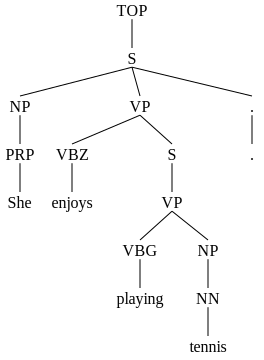

In [5]:
example_tree = nltk.Tree.fromstring(
    "(TOP (S (NP (PRP She)) (VP (VBZ enjoys) (S (VP (VBG playing) (NP (NN tennis))))) (. .)))")
example_tree

The `TetraTagSystem` class lets us convert trees to tag sequences.

In [6]:
example_tags = tag_system.tags_from_tree(example_tree)
example_ids = tag_system.ids_from_tree(example_tree)
print(example_tags)
print(example_ids)

['l/NP', 'L/S', 'l', 'L/VP', 'l', 'R/S/VP', 'r/NP', 'R', 'r']
[171, 48, 156, 66, 156, 128, 206, 79, 191]


It also lets us do the reverse.

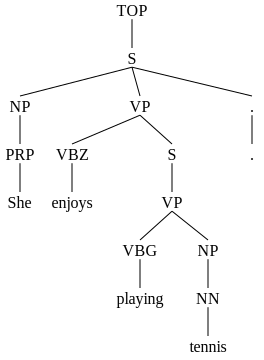

In [7]:
tag_system.tree_from_ids(example_ids, pos=example_tree.pos())

While a full NLP pipeline would define its own tokenizer and part-of-speech tagger, our code concerns itself with parsing only. For the purposes of displaying trees, we'll use part-of-speech tags provided in the dataset. Note that these parts of speech are never passed to the parser model itself, and the F1 evaluation metric also ignores part-of-speech decisions. 

In [8]:
pos = example_tree.pos()
pos

[('She', 'PRP'),
 ('enjoys', 'VBZ'),
 ('playing', 'VBG'),
 ('tennis', 'NN'),
 ('.', '.')]

## Model

Now let's load the trained parser model. We'll be using the token classification model type (`AutoModelForTokenClassification`) provided by the transformers library. This class works out of the box for inference, though it doesn't actually provide the right loss for training the model.

We've already loaded the `config` previously, so now we just need the model and the tokenizer.

In [9]:
model = transformers.AutoModelForTokenClassification.from_pretrained(
    'kitaev/tetra-tag-en', config=config)
model.eval().to(device)  # Switch model to eval mode on GPU
tokenizer = transformers.AutoTokenizer.from_pretrained(
    'kitaev/tetra-tag-en', use_fast=True)

For our input pipeline, we'll need some helper code to adjust some of the escape sequences used in the Penn Treebank data format.

In [10]:
BERT_TOKEN_MAPPING = {
    "-LRB-": "(",
    "-RRB-": ")",
    "-LCB-": "{",
    "-RCB-": "}",
    "-LSB-": "[",
    "-RSB-": "]",
    "``": '"',
    "''": '"',
    "`": "'",
    '«': '"',
    '»': '"',
    '‘': "'",
    '’': "'",
    '“': '"',
    '”': '"',
    '„': '"',
    '‹': "'",
    '›': "'",
    "\u2013": "--", # en dash
    "\u2014": "--", # em dash
    }

def ptb_unescape(sent):
  cleaned_words = []
  for word in sent:
      word = BERT_TOKEN_MAPPING.get(word, word)
      word = word.replace('\\/', '/').replace('\\*', '*')
      # Mid-token punctuation occurs in biomedical text
      word = word.replace('-LSB-', '[').replace('-RSB-', ']')
      word = word.replace('-LRB-', '(').replace('-RRB-', ')')
      if word == "n't" and cleaned_words:
          cleaned_words[-1] = cleaned_words[-1] + "n"
          word = "'t"
      cleaned_words.append(word)
  return cleaned_words

And now our main code for parsing:

In [11]:
def parse_batch(batched_pos):
  all_input_ids = []
  all_label_mask = []
  for pos in batched_pos:
    words = ptb_unescape([word for word, _ in pos])
    encoded = tokenizer.encode_plus(' '.join(words))
    input_ids = torch.tensor(encoded['input_ids'], dtype=torch.long)
    word_end_positions = [
        encoded.char_to_token(i)
        for i in np.cumsum([len(word) + 1 for word in words]) - 2]
    label_mask = torch.zeros_like(input_ids, dtype=bool)
    label_mask[word_end_positions] = True

    all_input_ids.append(input_ids)
    all_label_mask.append(label_mask)
  input_ids = pad_sequence(
      all_input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
  all_label_mask = pad_sequence(
      all_label_mask, batch_first=True, padding_value=False).numpy()

  with torch.no_grad():
    input_ids = input_ids.to(device)
    attention_mask = (input_ids != tokenizer.pad_token_id)
    logits, = model(input_ids, attention_mask=attention_mask)
  logits = logits.cpu().numpy()
  
  predicted_trees = []
  for pos, label_mask, example_logits in zip(
      batched_pos, all_label_mask, logits):
    tree = tag_system.tree_from_logits(example_logits, label_mask, pos=pos)
    predicted_trees.append(tree)
  return predicted_trees

def parse(dataset_pos, batch_size=32):
  # Batch by length to speed up inference
  # (longest sentence first to catch any OOM errors early)
  sort_keys = sorted(
      range(len(dataset_pos)), key=lambda i: -len(dataset_pos[i]))
  sorted_dataset_pos = [dataset_pos[i] for i in sort_keys]

  predicted_trees = []
  for start_index in tqdm.notebook.trange(
      0, len(sorted_dataset_pos), batch_size, unit='batch'):
    batch_pos = sorted_dataset_pos[start_index:start_index+batch_size]
    predicted_trees.extend(parse_batch(batch_pos))

  # Undo sort by length
  predicted_trees = [
      tree for (_, tree) in sorted(enumerate(predicted_trees),
                                   key=lambda x: sort_keys[x[0]])]
  return predicted_trees

The `parse` method accepts a list of examples, and outputs a list of trees.

Let's parse our example sentence and see if we get it right.


Correct? = True


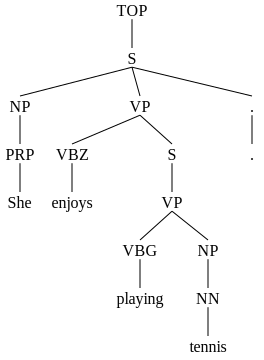

In [12]:
tree = parse([pos])[0]
print('Correct? =', tree == example_tree)
tree

## Evaluation

Now, let's evaluate the performance of the  parser on the Penn Treebank. Following the standard splits, sections 2-21 are used for training, section 22 for validation, and section 23 for testing.

We'll start by downloading the dataset and a copy of the EVALB program.

In [13]:
%%bash
if [ ! -e self-attentive-parser ]; then
  git clone https://github.com/nikitakit/self-attentive-parser &> /dev/null
fi
rm -rf train dev test EVALB/
cp self-attentive-parser/data/02-21.10way.clean ./train
cp self-attentive-parser/data/22.auto.clean ./dev
cp self-attentive-parser/data/23.auto.clean ./test
# The evalb program needs to be compiled
cp -R self-attentive-parser/EVALB EVALB
cd EVALB && make &> /dev/null
# To test that everything works as intended, we check that the F1 score when
# comparing the dev set with itself is 100.
./evalb -p nk.prm ../dev ../dev | grep FMeasure | head -n 1

Bracketing FMeasure       = 100.00


The dataset files include one tree per line. We'll use the `BracketParseCorpusReader` from `nltk` to load the data.

In [14]:
READER = BracketParseCorpusReader('.', ['train', 'dev', 'test'])

Now we can parse the development set with our parser.

In [15]:
predicted_dev_trees = parse(READER.tagged_sents('dev'), batch_size=32)

Next we call `evalb` to compute the F-score.

The model should have a development score of 95.24 F1 for all sentences, and 95.48 F1 for sentences that are at most 40 words long.

In [16]:
with open('./dev_predictions.txt', 'w') as f:
  for tree in predicted_dev_trees:
    f.write(' '.join(str(tree).split()) + '\n')

!EVALB/evalb -p EVALB/nk.prm dev dev_predictions.txt | tail -n 27

-- All --
Number of sentence        =   1700
Number of Error sentence  =      0
Number of Skip  sentence  =      0
Number of Valid sentence  =   1700
Bracketing Recall         =  95.30
Bracketing Precision      =  95.18
Bracketing FMeasure       =  95.24
Complete match            =  54.76
Average crossing          =   0.24
No crossing               =  87.35
2 or less crossing        =  97.18
Tagging accuracy          = 100.00

-- len<=40 --
Number of sentence        =   1578
Number of Error sentence  =      0
Number of Skip  sentence  =      0
Number of Valid sentence  =   1578
Bracketing Recall         =  95.45
Bracketing Precision      =  95.51
Bracketing FMeasure       =  95.48
Complete match            =  57.29
Average crossing          =   0.20
No crossing               =  88.78
2 or less crossing        =  97.85
Tagging accuracy          = 100.00
